In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
# from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

import pickle
from spec_tools import Gen_SFH

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


Couldn't `import tristars`.  Get it from https://github.com/gbrammer/tristars to enable improved blind astrometric matching with triangle asterisms.



In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
morph_db = alldb.query('W_UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144]
# nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]
# nog102 = []

inout = []
for i in morph_db.index:     
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [9]:
min(mdb.query('Sigma1 > 10**10.25').z_50)

2.917489232868667

In [4]:
eazy_GSD = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()
eazy_GND = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()

Text(0,0.5,'EAZY lmass')

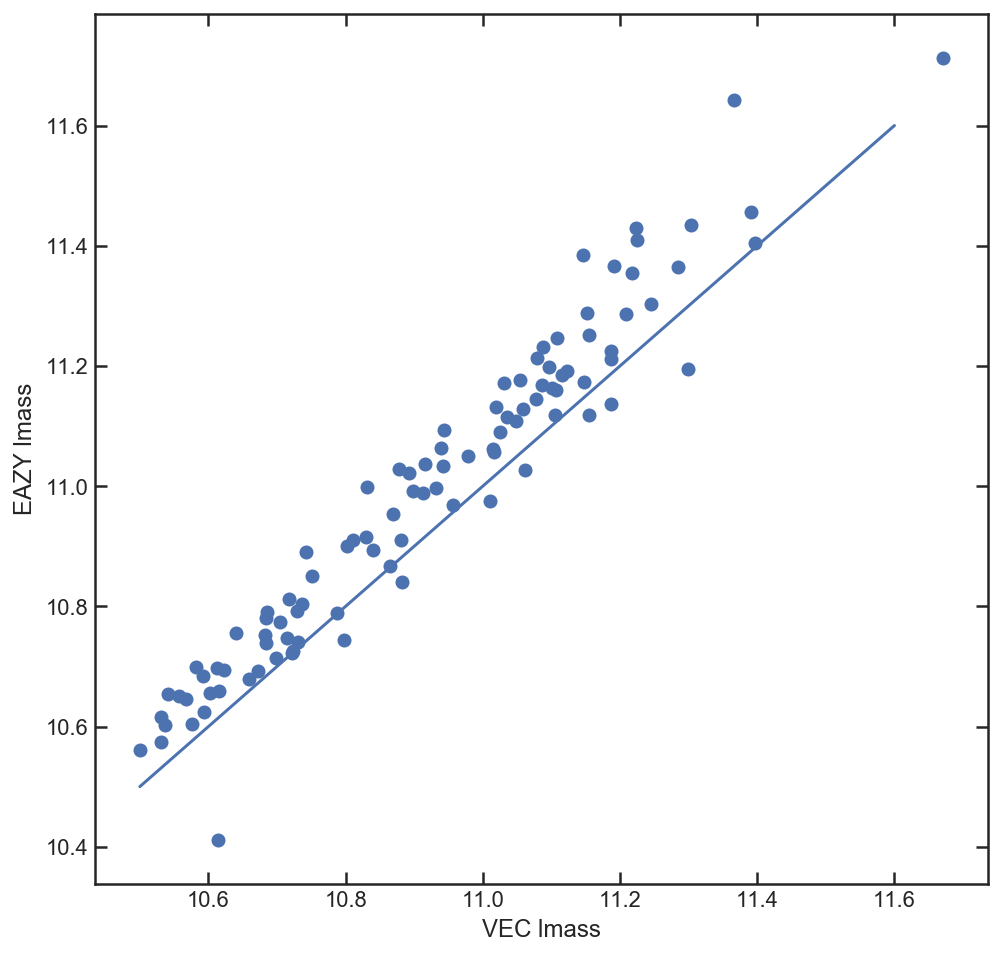

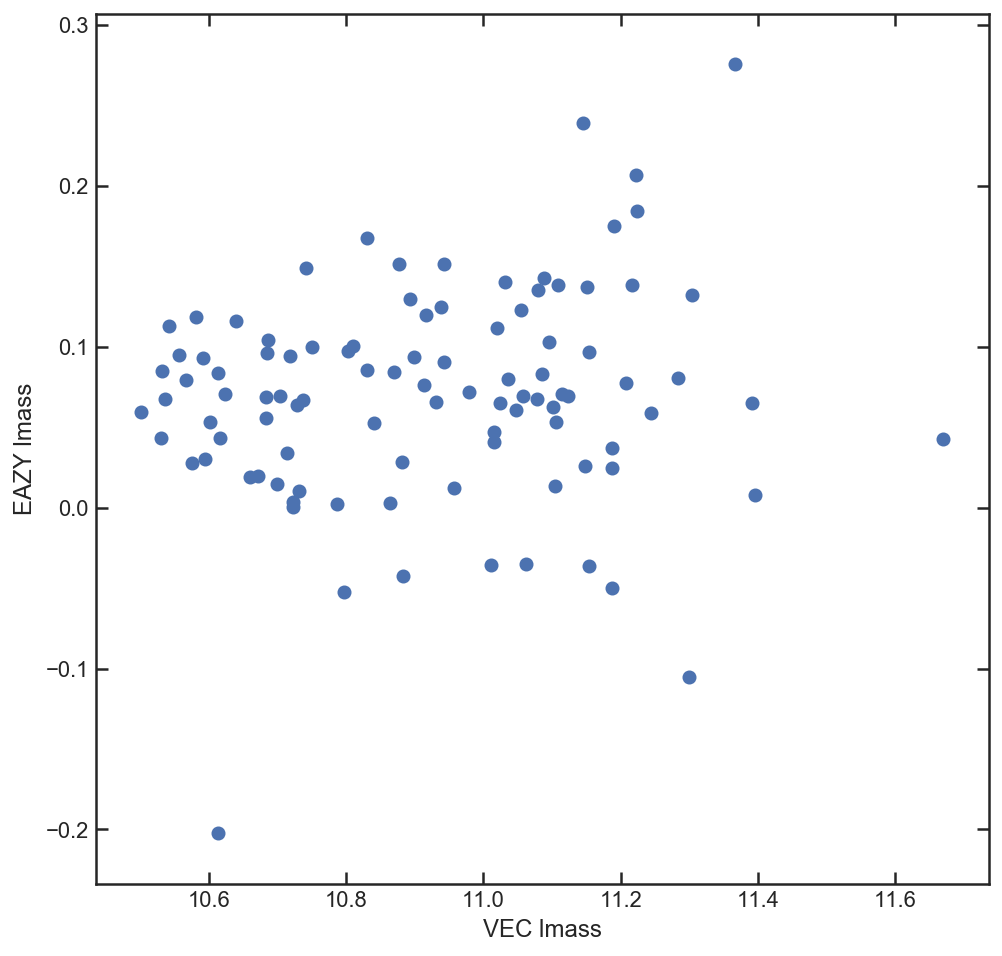

In [11]:

plt.figure(figsize=[8,8])
ax1 = plt.subplot()
ezmasses = []
for i in mdb.index:
    if mdb.field[i] == 'GSD':
        ezmass = np.log10(eazy_GSD.query('id == {}'.format(mdb.id[i])).mass.values[0])
    else:
        ezmass = np.log10(eazy_GND.query('id == {}'.format(mdb.id[i])).mass.values[0])      
    ezmasses.append(ezmass)

ezmasses = np.array(ezmasses)
    
ax1.scatter(mdb.lmass,ezmasses)

ax1.plot([10.5,11.6],[10.5,11.6])
ax1.set_xlabel('VEC lmass')
ax1.set_ylabel('EAZY lmass')


plt.figure(figsize=[8,8])
ax1 = plt.subplot()

ax1.scatter(mdb.lmass,ezmasses - mdb.lmass)
ax1.set_xlabel('VEC lmass')
ax1.set_ylabel('EAZY lmass')


In [14]:
offset = np.linspace(0.05,0.1)
chi2 = []
for i in offset:
    irange = interp1d(np.linspace(10,12), np.repeat(i, 50))
    
    chi2.append(sum(((ezmasses - mdb.lmass) - irange(mdb.lmass))**2))

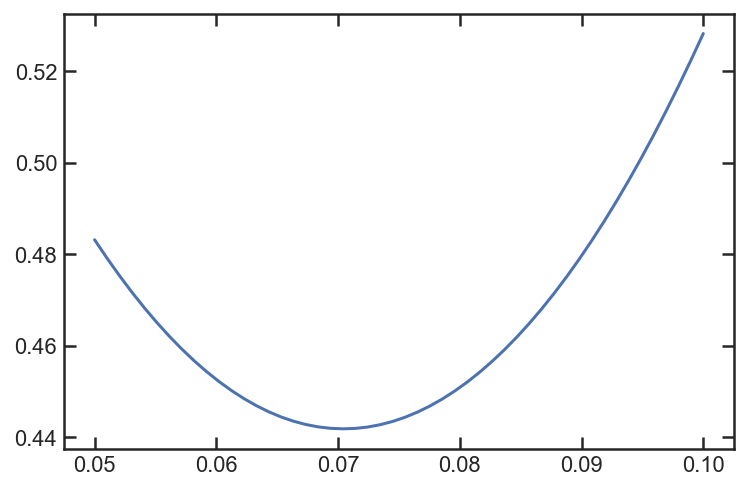

In [15]:
plt.plot(offset, chi2)

# Dust v SFR

In [37]:
sSFR = []

for idx in mdb.index:
    
    with open('../data/SFH/{}_{}_1D.pkl'.format( mdb.field[idx],  mdb.id[idx]), 'rb') as sfh_file:
        SFH = pickle.load(sfh_file)
    
    sSFR.append(np.log10((np.trapz(SFH.SFH[:11], SFH.LBT[:11])/0.1) / 10**mdb.lmass[idx]))

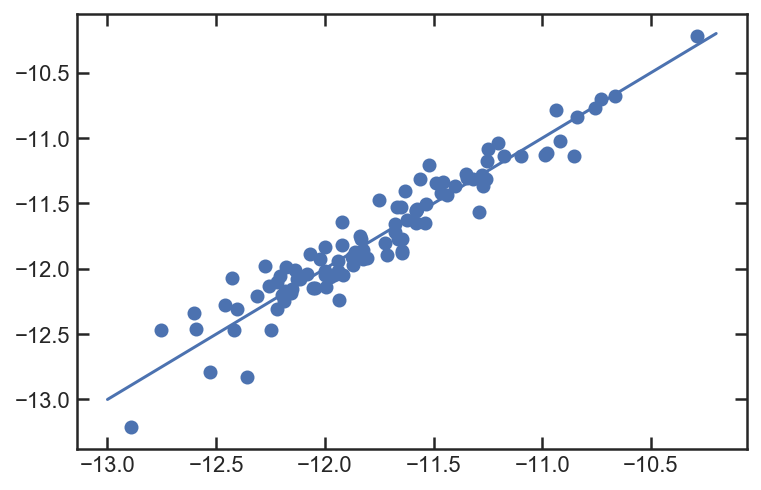

In [40]:
plt.scatter(sSFR, mdb.log_ssfr)
plt.plot([-13, -10.2],[-13, -10.2])

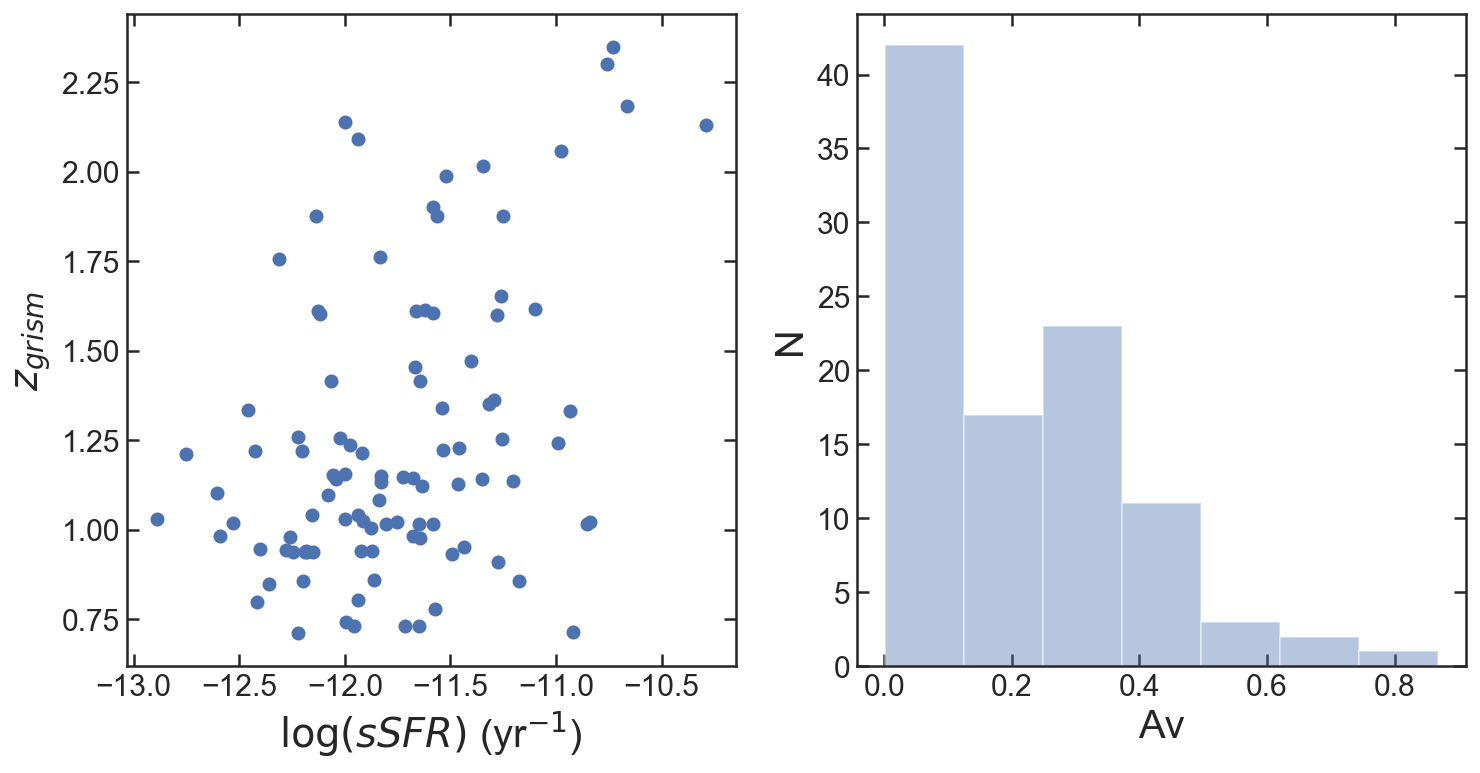

In [50]:
gs = gridspec.GridSpec(1,2)
plt.figure(figsize=[12,6])
ax1 = plt.subplot(gs[0])
plt.scatter(sSFR, mdb.zgrism)
ax2 = plt.subplot(gs[1])
sea.distplot(mdb.Av, kde =False)

ax1.set_xlabel('$\log(sSFR)$ (yr$^{-1}$)', fontsize=20)
ax2.set_xlabel('Av', fontsize=20)
ax1.set_ylabel('$z_{grism}$', fontsize=20)
ax2.set_ylabel('N', fontsize=20)

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('../plots/sSFR_Av.png', bbox_inches = 'tight')    


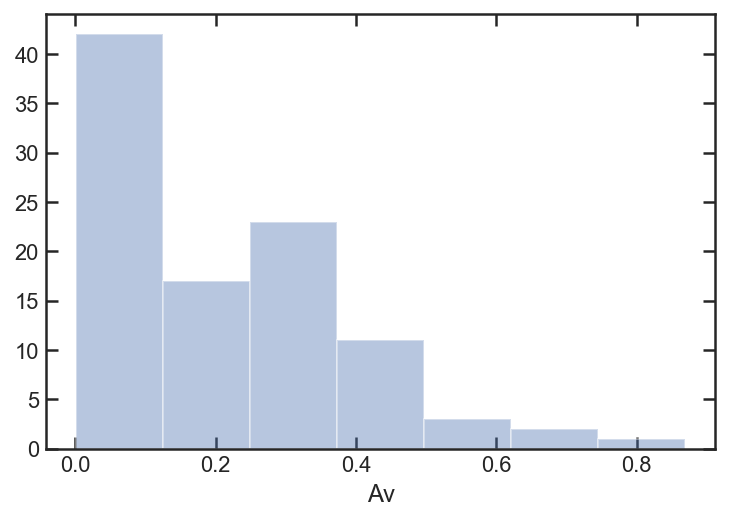

In [43]:
sea.distplot(mdb.Av, kde =False)

In [51]:
max(sSFR)

-10.290448267914766

# emission lines

In [53]:
swave, azflux, azerror = np.load('../data/plot_points/all_stacked.npy')

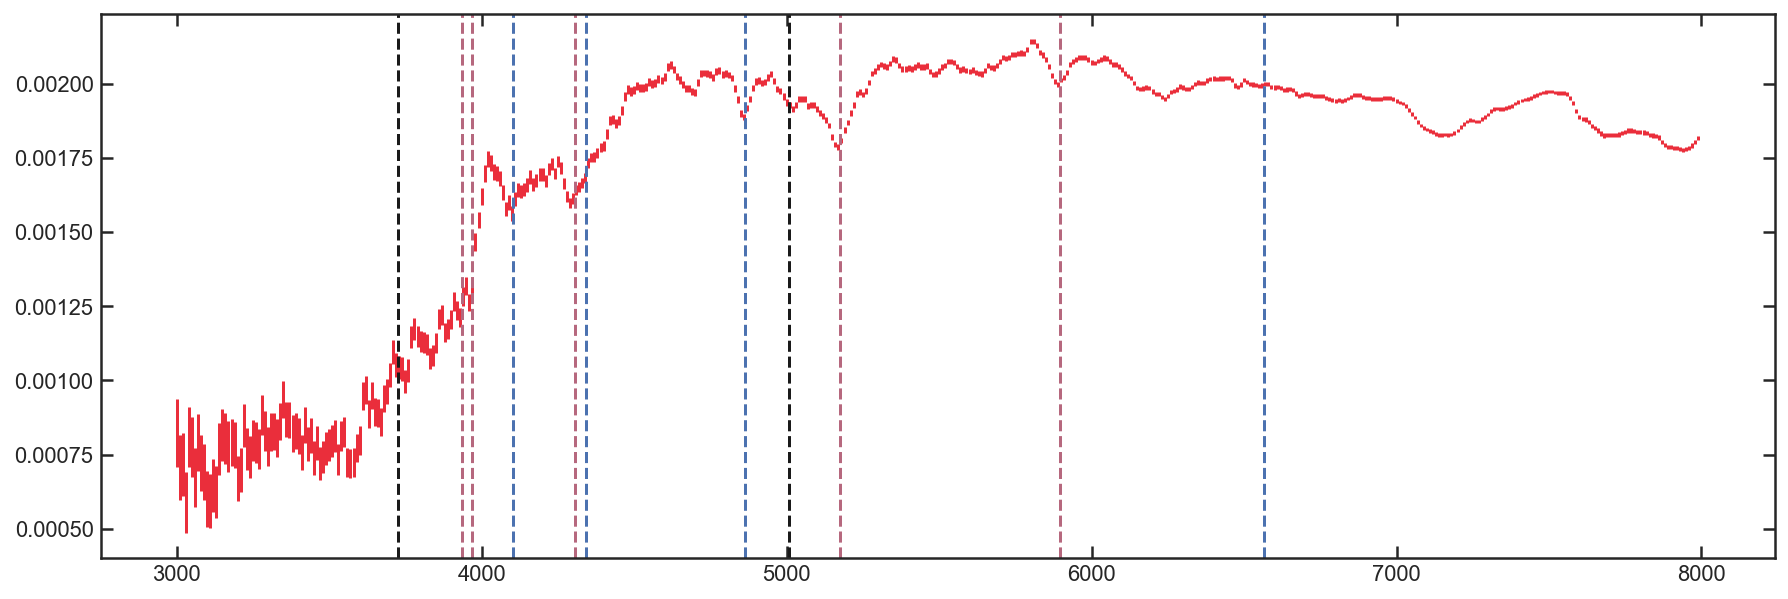

In [54]:
plt.figure(figsize=[15,5])

plt.errorbar(swave, azflux, azerror, linestyle = 'none', color='#EA2E3B',)

plt.axvline(3727 ,linestyle='--', color = 'k')
plt.axvline(5008 ,linestyle='--', color = 'k')

plt.axvline(3934.77 ,linestyle='--', color = '#B6687E')
plt.axvline(3969.588 ,linestyle='--', color = '#B6687E')

plt.axvline(4305.61 ,linestyle='--', color = '#B6687E')
plt.axvline(5176.7,linestyle='--', color = '#B6687E')
plt.axvline(5895.6,linestyle='--', color = '#B6687E')

plt.axvline(4102.89 ,linestyle='--', color = 'b')
plt.axvline(4341.68 ,linestyle='--', color = 'b')
plt.axvline(4862.68 ,linestyle='--', color = 'b')
plt.axvline(6564.61,linestyle='--', color = 'b')

# table

In [56]:
v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
eazy_GSD = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()
eazy_GND = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()

In [ ]:
allz = pd.read_pickle('../dataframes/galaxy_frames/all_redshifts.pkl')

zphot = []
zphot_16 = []
zphot_84 = []

for i in mdb.index:
    sml = allz.query('ID == {} and Field == "{}"'.format(alldb.id[i], alldb.field[i]))
    sml = sml.sort_values('red_CHI')
    
    zphot.append(sml.zphot_50.values[0])
    zphot_16.append(sml.zphot_16.values[0])
    zphot_84.append(sml.zphot_84.values[0])

zphot = np.array(zphot)
zphot_16 = np.array(zphot_16)
zphot_84 = np.array(zphot_84)

In [107]:
allz = pd.read_pickle('../dataframes/galaxy_frames/all_redshifts.pkl')

ra = []
dec = []
massez = []
lS1 = []
dS1 = []
zphot = []
zphot_16 = []
zphot_84 = []
t_q = []
t_qerr = []

for i in mdb.index:
    if mdb.field[i] == 'GND':
        ra.append(v4N.query('id == {}'.format(mdb.id[i])).ra.values[0] )
        dec.append(v4N.query('id == {}'.format(mdb.id[i])).dec.values[0] )     
        massez.append(np.log10(eazy_GND.query('id == {}'.format(mdb.id[i])).mass.values[0]))
    if mdb.field[i] == 'GSD':
        ra.append( v4S.query('id == {}'.format(mdb.id[i])).ra.values[0] )
        dec.append( v4S.query('id == {}'.format(mdb.id[i])).dec.values[0] )  
        massez.append(np.log10(eazy_GSD.query('id == {}'.format(mdb.id[i])).mass.values[0]))

    lS1.append(np.log10(mdb.Sigma1[i]))
    dS1.append(mdb.Sigma1_sig[i] / (mdb.Sigma1[i] * np.log(10)))

    sml = allz.query('ID == {} and Field == "{}"'.format(alldb.id[i], alldb.field[i]))
    sml = sml.sort_values('red_CHI')
    
    zphot.append(sml.zphot_50.values[0])
    zphot_16.append(sml.zphot_50.values[0] - sml.zphot_16.values[0])
    zphot_84.append(sml.zphot_84.values[0] - sml.zphot_50.values[0])

    t_q.append(mdb.t_50[i] - mdb.t_90[i])
    
    err = []
    for ii in range(2):
        err50 = np.abs(mdb.t_50[i] - mdb.t_50_hdr[i][ii])
        err90 = np.abs(mdb.t_90[i] - mdb.t_90_hdr[i][ii])
        
        err.append(np.sqrt(err50**2 + err90**2))
    t_qerr.append(err)

In [108]:
mdb['ra'] = ra
mdb['dec'] = dec
mdb['massez'] = massez
mdb['lS1'] = lS1
mdb['dS1'] = dS1
mdb['zphot'] = zphot
mdb['zphot_16'] = zphot_16
mdb['zphot_84'] = zphot_84
mdb['t_q'] = t_q
mdb['t_qerr'] = t_qerr
mdb['sSFR_m'] = sSFR
# ra dec zphot, zgrism, mass ez, mass r1/2, SFR, Av, z50, Sigma1, t_Q

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [81]:
mdb[['field', 'id', 'ra', 'dec', 'zphot', 'zphot_16', 'zphot_84', 'zgrism', 'zgrism_hdr', 'massez', 'lmass', 'lmass_hdr',\
    'Re', 'Re_sig', 'sSFR_m', 'log_ssfr_hdr', 'Av', 'Av_hdr', 'lS1', 'dS1', 't_q', 't_qerr']]

,field,id,ra,dec,zphot,zphot_16,zphot_84,zgrism,zgrism_hdr,massez,...,Re,Re_sig,sSFR_m,log_ssfr_hdr,Av,Av_hdr,lS1,dS1,t_q,t_qerr
2,GSD,40862,53.048020,-27.719743,1.341581,1.328374,1.358418,1.333095,"[1.3293190186710149, 1.3383820167162035]",11.185341,...,2.713480,0.027701,-10.934574,"[-10.922096377764401, -10.655386419021397]",0.454612,"[0.41118994718654833, 0.5034610756904888]",9.901061,0.019993,-1.511049,"[0.22217699190018492, 0.1467515382845418]"
10,GSD,39850,53.173100,-27.724355,0.955095,0.946396,0.966029,0.979554,"[0.9786141353946796, 0.9808485318372173]",10.691569,...,0.907649,0.010018,-12.258375,"[-12.687755282200474, -11.822859511170908]",0.036295,"[0.016803984115102012, 0.08158322099994794]",9.966326,0.019593,-1.847835,"[0.5754191259072191, 0.17137396177420114]"
14,GND,37186,189.243199,62.349892,0.804812,0.791553,0.820127,0.803694,"[0.8024745353841467, 0.8051371595533952]",10.989310,...,1.677268,0.026763,-11.936868,"[-12.554183537758721, -11.968374077661974]",0.009988,"[0.001831379718429112, 0.05776025457538027]",10.046497,0.023821,-1.356772,"[0.48794470659860545, 0.3651008700671391]"
17,GND,22358,189.081040,62.251545,0.817907,0.802848,0.833488,0.778565,"[0.7737427105702068, 0.7838246403150887]",10.713567,...,1.661192,0.016135,-11.573952,"[-11.713134531090367, -11.36000552040102]",0.182483,"[0.13058843847191903, 0.2603252190371288]",9.767972,0.030863,-1.883299,"[0.5810276688995484, 0.48648751693483433]"
19,GND,22246,189.220896,62.252424,0.874824,0.863355,0.884123,0.941617,"[0.9407654295467909, 0.942347469037385]",11.108726,...,3.580421,0.032012,-12.182614,"[-12.420156953252302, -11.923598731151914]",0.001428,"[0.0014278313927940918, 0.015083719903173266]",10.039211,0.014930,-2.227326,"[0.8554011248974759, 0.6031594512301106]"
24,GND,17746,189.049436,62.228979,1.161801,1.149230,1.178638,1.151755,"[1.1428952431606403, 1.1595073836113978]",11.127820,...,1.322862,0.040718,-12.055133,"[-12.588986889210982, -11.71359023500046]",0.349922,"[0.2603823958654308, 0.452891995598498]",10.239328,0.037884,-1.479628,"[0.6461199134695845, 0.40077211363646736]"
25,GSD,39631,53.042169,-27.725928,0.993757,0.979498,1.009822,1.028802,"[1.026126015837392, 1.0322913767301936]",10.991869,...,2.244815,0.026900,-12.890866,"[-13.600630361691952, -12.310258537452038]",0.249305,"[0.21795210285217748, 0.36359201614875625]",9.975111,0.020742,-0.863682,"[1.7712147490239212, 0.3528033358813842]"
33,GND,20432,189.362767,62.242309,1.136814,1.116000,1.156998,1.149262,"[1.1429843589349553, 1.1546101598920768]",11.063220,...,1.146548,0.014703,-11.826576,"[-12.177403382058525, -11.597479854005453]",0.192891,"[0.14370017474255065, 0.3188209737772886]",10.135053,0.027084,-1.494774,"[0.523645448025413, 0.4823720279837196]"
35,GSD,39012,53.064240,-27.727621,1.616861,1.581039,1.657225,1.612016,"[1.6068108934706729, 1.6176206058223757]",11.288514,...,1.624542,0.047002,-11.662104,"[-12.017776656309277, -11.56439028772684]",0.491376,"[0.4410732747103688, 0.561439774922537]",10.201679,0.019500,-0.330646,"[0.7965302805669697, 0.26547943100711696]"
37,GND,16758,189.162357,62.224840,0.981848,0.967393,0.996635,1.016235,"[1.0149490533572125, 1.0176335438819937]",11.050167,...,1.454510,0.014203,-11.650836,"[-11.87790662140134, -11.240479913132631]",0.563701,"[0.512329566425902, 0.6222407649997757]",10.067439,0.039248,-1.169849,"[0.6293573334100123, 0.5293908854997452]"


In [109]:
for idx in mdb.sort_values('zgrism').index:
    print('%s-%d & %f & %f & $%1.2f_{%1.2f}^{%1.2f}$ & $%1.3f_{%1.3f}^{%1.3f}$ & %1.2f & $%1.2f\
_{%1.2f}^{%1.2f}$ & %1.2f $\pm$ %1.2f & $%1.2f_{%1.2f}^{%1.2f}$ & $%1.2f_{%1.2f}^{%1.2f}$ \
& %1.2f $\pm$ %1.2f & $%1.2f_{%1.2f}^{%1.2f}$ \\\\' % (
    mdb.field[idx], mdb.id[idx], mdb.ra[idx], mdb.dec[idx], mdb.zphot[idx], mdb.zphot_16[idx], mdb.zphot_84[idx], mdb.zgrism[idx], 
    mdb.zgrism[idx]-mdb.zgrism_hdr[idx][0],mdb.zgrism_hdr[idx][1]-mdb.zgrism[idx], mdb.massez[idx], mdb.lmass[idx], 
    mdb.lmass[idx] - mdb.lmass_hdr[idx][0],mdb.lmass_hdr[idx][1]-mdb.lmass[idx],
    mdb.Re[idx], mdb.Re_sig[idx], mdb.sSFR_m[idx], np.abs(mdb.sSFR_m[idx]-mdb.log_ssfr_hdr[idx][0]), 
    np.abs(mdb.log_ssfr_hdr[idx][1]-mdb.sSFR_m[idx]), mdb.Av[idx], 
    mdb.Av_hdr[idx][0],mdb.Av_hdr[idx][1], mdb.lS1[idx], mdb.dS1[idx], mdb.t_q[idx], mdb.t_qerr[idx][0], mdb.t_qerr[idx][1]))

GND-29879 & 189.254227 & 62.291579 & $0.69_{0.01}^{0.01}$ & $0.711_{0.002}^{0.001}$ & 10.90 & $10.80_{0.03}^{0.04}$ & 1.12 $\pm$ 0.01 & $-12.22_{0.36}^{0.46}$ & $0.22_{0.14}^{0.30}$ & 9.99 $\pm$ 0.03 & $1.27_{0.75}^{0.43}$ \\
GND-21683 & 189.318225 & 62.253421 & $0.66_{0.01}^{0.01}$ & $0.715_{0.004}^{0.004}$ & 11.19 & $11.30_{0.03}^{0.03}$ & 6.73 $\pm$ 0.03 & $-10.92_{0.24}^{0.09}$ & $0.38_{0.31}^{0.45}$ & 10.21 $\pm$ 0.03 & $1.77_{0.67}^{0.41}$ \\
GSD-41147 & 53.081634 & -27.717718 & $0.70_{0.01}^{0.01}$ & $0.730_{0.002}^{0.002}$ & 10.80 & $10.74_{0.02}^{0.02}$ & 1.46 $\pm$ 0.01 & $-11.65_{0.42}^{0.02}$ & $0.20_{0.15}^{0.24}$ & 9.96 $\pm$ 0.02 & $2.48_{0.46}^{0.28}$ \\
GSD-47140 & 53.131853 & -27.687304 & $0.73_{0.01}^{0.01}$ & $0.731_{0.002}^{0.002}$ & 10.77 & $10.70_{0.02}^{0.03}$ & 2.91 $\pm$ 0.04 & $-11.96_{0.24}^{0.06}$ & $0.00_{0.00}^{0.02}$ & 9.71 $\pm$ 0.03 & $1.90_{1.07}^{0.37}$ \\
GSD-46001 & 53.120312 & -27.691486 & $0.72_{0.01}^{0.01}$ & $0.732_{0.001}^{0.001}$ & 11.16 & $

In [91]:
len([mdb.field[idx], mdb.id[idx], mdb.ra[idx], mdb.dec[idx], mdb.zphot[idx], mdb.zphot_16[idx], mdb.zphot_84[idx], mdb.zgrism[idx], 
    mdb.zgrism[idx] - mdb.zgrism_hdr[idx][0],mdb.zgrism_hdr[idx][1]-mdb.zgrism[idx], mdb.massez[idx], mdb.lmass[idx], mdb.lmass_hdr[idx][0],mdb.lmass_hdr[idx][1],
    mdb.Re[idx], mdb.Re_sig[idx], mdb.sSFR_m[idx], mdb.log_ssfr_hdr[idx][0], mdb.log_ssfr_hdr[idx][1], mdb.Av[idx], 
    mdb.Av_hdr[idx][0],mdb.Av_hdr[idx][1], mdb.lS1[idx], mdb.dS1[idx], mdb.t_q[idx], mdb.t_qerr[idx][0], mdb.t_qerr[idx][1]])

27

In [ ]:
'id', 'ra', 'dec', 'zphot', 'zgrism', 'massez', 'lmass', 'Re', 'sSFR_m', 'Av','lS1','t_q'